In [1]:
!ls saved_models/

2018_05_11_07:43:16.726337_ffffffffff_resnet34_None_None.pth
2018_05_11_07:52:37.371781_ffaaabaaabaa_resnet34_l2_full.pth
2018_05_11_08:29:03.086237_ffffffffff_inception_v3_None_None_inception.pth
2018_05_11_10:06:09.015206_ffffffffff_resnet50_None_None_layer4_fc.pth
2018_05_11_10:21:38.412821_ffaaabaaabaa_resnet50_l2_full_layer4_fc.pth
2018_05_11_21:41:20.255008_faaa_resnet50_l2_full.pth
l1.pth


In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
from AttentionModule import Conv2d_Attn

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [5]:
m = torch.load('saved_models/l1.pth')

In [6]:
# This block turns 'layer1.0.downsample.0.weight' to 'layer1[0].downsample[0].weight'
def get_formatted_keys(network_name):
    param_keys = list(eval(network_name).state_dict().keys())
    formatted_keys = []
    for k in param_keys:
        found = re.findall(r'\.[\d]{1,2}\.', k)
        if len(found):
            for f in found:
                k = k.replace(f, '[{}].'.format(f.strip('.')))
        formatted_keys.append(k)
    return formatted_keys
    
# This block turn off gradient up for all params except attn_weights
def turn_off_grad_except(network_name, lst=[]):
    formatted_keys = get_formatted_keys(network_name)
    for k in formatted_keys:
        obj = eval(f'{network_name}.'+k)
        for kw in lst:
            if not kw in k:
                obj.requires_grad = False
            else:
                obj.requires_grad = True

In [7]:
def get_params_objs(name, net):
    res = []
    for k in get_formatted_keys(net):
        obj = eval(f'{net}.'+k)
        if name in k:
            res.append(obj)
    return res

In [8]:
import re

In [9]:
objs = get_params_objs('attn', 'm')

In [10]:
o = objs[0]

In [11]:
flat = [o.squeeze().view(-1).data.cpu().numpy() for o in objs]

In [12]:
cat = np.concatenate(flat).clip(min=0,max=2)

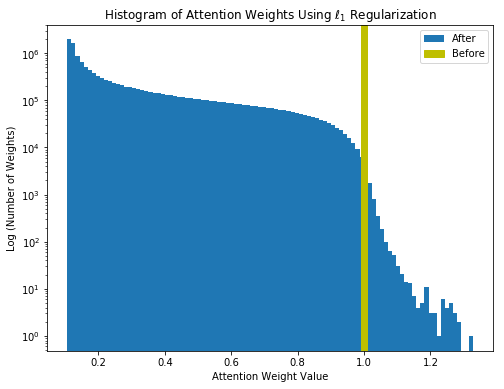

In [15]:
plt.figure(figsize=(8,6))
plt.hist(cat, bins=100, log=True, label='After')
plt.axvspan(0.99, 1.01, label='Before', color='y')
plt.legend()
plt.title(r"Histogram of Attention Weights Using $\ell_1$ Regularization")
plt.xlabel('Attention Weight Value')
plt.ylabel('Log (Number of Weights)')
plt.savefig('hist_1.png')